<a href="https://colab.research.google.com/github/pacificblue/Data-Science-Hands-on-Projects/blob/main/Review_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.4.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GRU, SimpleRNN, Embedding, Dropout
from tensorflow.keras.models import Model

In [3]:
!head review_data_with_labels.csv

review,label
"I had to click one star--that's all it's worth.  This item is a definite knock off--I brought it to Sephora where I always purchase my They're Real Mascara, and the sales person agreed it was definitely not the same mascara.  I wouldn't use anything on my eyes that is questionable, at best, so I'm throwing this out and contacting the seller requesting a refund.",0
"I tried to use this to take foundation with me during travel.  I thought it would be so much more hygienic than a little pot container and smaller than taking a full bottle.  While it was easy to fill, nothing would be dispensed!  I do not use a thick foundation - it is liquid.  Nothing would come out of the bottle and you can't re-open it to even try to get the foundation back.  Disappointed.",0
"This plate is a cheap knockoff. It took forever to arrive (came from China apparently, so that explains it). When I got it, I was so excited but started to get concerned when I looked at it more closely. The design pl

In [4]:
df = pd.read_csv("review_data_with_labels.csv", encoding='latin-1')

In [5]:
df.head()

,review,label
0,I had to click one star--that's all it's worth...,0
1,I tried to use this to take foundation with me...,0
2,This plate is a cheap knockoff. It took foreve...,0
3,I truly wanted something easy and was worried ...,0
4,When I saw this headband in the picture I thou...,0


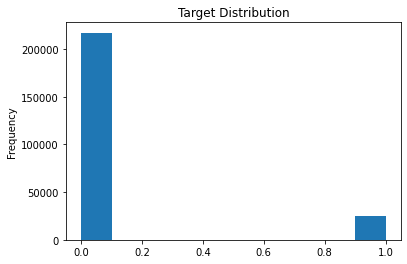

In [6]:
df.label.plot(kind="hist", title="Target Distribution")

In [7]:
# split up the data
df_train, df_remain, Ytrain, Yremain = train_test_split(df['review'], df['label'], train_size=0.05, random_state=42, stratify=df.label.values)
df_test, _, Ytest, _ = train_test_split(df_remain, Yremain, train_size=0.01, random_state=42, stratify=Yremain.values)
df_train.shape, Ytrain.shape, df_test.shape, Ytest.shape

((12099,), (12099,), (2299,), (2299,))

In [8]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [9]:
sequences_train[0]

[2,
 15,
 477,
 14,
 6,
 23,
 12,
 15858,
 1089,
 3444,
 924,
 1090,
 1,
 84,
 935,
 9,
 7355,
 3542,
 203,
 3,
 66,
 9,
 2262,
 518,
 72,
 114,
 4901,
 1,
 206,
 3889,
 131,
 308,
 55,
 2,
 48,
 215,
 557,
 3444,
 924,
 35,
 369,
 80,
 74,
 1,
 360,
 1197,
 1,
 456,
 9,
 229,
 14,
 798,
 1,
 23]

In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 38321 unique tokens.


In [11]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (12099, 1926)


In [12]:
word2idx

{'the': 1,
 'i': 2,
 'and': 3,
 'it': 4,
 'to': 5,
 'a': 6,
 'of': 7,
 'this': 8,
 'is': 9,
 'in': 10,
 'br': 11,
 'that': 12,
 'my': 13,
 'for': 14,
 'was': 15,
 'not': 16,
 'but': 17,
 'on': 18,
 'with': 19,
 'have': 20,
 'as': 21,
 'you': 22,
 'product': 23,
 'so': 24,
 'be': 25,
 'like': 26,
 'one': 27,
 'are': 28,
 'they': 29,
 'all': 30,
 'hair': 31,
 'at': 32,
 'if': 33,
 'very': 34,
 'from': 35,
 'just': 36,
 'out': 37,
 'had': 38,
 'would': 39,
 'or': 40,
 'me': 41,
 'when': 42,
 "it's": 43,
 'no': 44,
 'an': 45,
 'after': 46,
 'get': 47,
 'will': 48,
 'what': 49,
 'up': 50,
 'use': 51,
 'more': 52,
 'about': 53,
 'has': 54,
 'time': 55,
 'movie': 56,
 'do': 57,
 'good': 58,
 'even': 59,
 'film': 60,
 'your': 61,
 'by': 62,
 'because': 63,
 'only': 64,
 "don't": 65,
 'there': 66,
 'used': 67,
 'did': 68,
 'really': 69,
 'them': 70,
 'his': 71,
 'which': 72,
 'can': 73,
 'than': 74,
 'some': 75,
 'he': 76,
 'much': 77,
 'been': 78,
 'well': 79,
 'other': 80,
 'skin': 81,
 'also

In [13]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (2299, 1926)


In [14]:
# Create the model

# We get to choose embedding dimensionality
D = 30

# Hidden state dimensionality
M = 10

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

dropout_rate = 0.5

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(dropout_rate)(x)
x = GRU(M, return_sequences=True)(x)
x = Dropout(dropout_rate)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1926)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1926, 30)          1149660   
_________________________________________________________________
dropout (Dropout)            (None, 1926, 30)          0         
_________________________________________________________________
gru (GRU)                    (None, 1926, 10)          1260      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1926, 10)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11    

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [17]:

print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=15,
  validation_data=(data_test, Ytest),
  callbacks=[early_stop]
)

Training model...
Epoch 1/15
379/379 [==============================] - 30s 68ms/step - loss: 0.4392 - accuracy: 0.8118 - val_loss: 0.2204 - val_accuracy: 0.9056
Epoch 2/15
379/379 [==============================] - 25s 66ms/step - loss: 0.1287 - accuracy: 0.9375 - val_loss: 0.1603 - val_accuracy: 0.9539
Epoch 3/15
379/379 [==============================] - 25s 66ms/step - loss: 0.0831 - accuracy: 0.9668 - val_loss: 0.1343 - val_accuracy: 0.9604
Epoch 4/15
379/379 [==============================] - 25s 65ms/step - loss: 0.0468 - accuracy: 0.9861 - val_loss: 0.1089 - val_accuracy: 0.9748
Epoch 5/15
379/379 [==============================] - 25s 65ms/step - loss: 0.0259 - accuracy: 0.9942 - val_loss: 0.0962 - val_accuracy: 0.9726
Epoch 6/15
379/379 [==============================] - 25s 66ms/step - loss: 0.0157 - accuracy: 0.9963 - val_loss: 0.0991 - val_accuracy: 0.9674
Epoch 7/15
379/379 [==============================] - 25s 66ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.08

In [18]:
losses = pd.DataFrame(model.history.history)

In [19]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.313637,0.886520,0.220432,0.905611
1,0.119025,0.944954,0.160311,0.953893
2,0.075220,0.972394,0.134329,0.960418
3,0.046077,0.985205,0.108884,0.974772
4,0.024489,0.993388,0.096241,0.972597


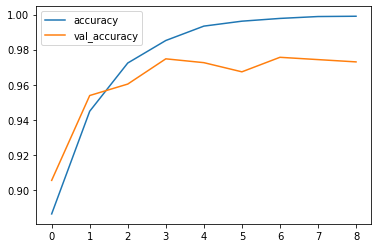

In [20]:
losses[['accuracy','val_accuracy']].plot()

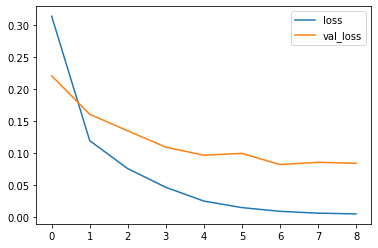

In [21]:
losses[['loss','val_loss']].plot()

In [22]:
print(model.metrics_names)
print(model.evaluate(data_test,Ytest,verbose=0))

['loss', 'accuracy']
[0.08358103781938553, 0.973031759262085]


In [23]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict(data_test)

Thresh_hold = 0.1
predictions = [1 if x>Thresh_hold else 0 for x in predictions]

In [24]:
print(classification_report(Ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2063
           1       0.78      0.97      0.86       236

    accuracy                           0.97      2299
   macro avg       0.89      0.97      0.92      2299
weighted avg       0.97      0.97      0.97      2299



In [25]:
 tn, fp, fn, tp = confusion_matrix(Ytest,predictions).ravel()
(tn, fp, fn, tp)

(1999, 64, 8, 228)